In [54]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [55]:
pfcn_small = np.load(r'/Users/sunhyeoklee/Desktop/AdvanceProject/pfcn_small.npz')

In [56]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

In [57]:
train_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images]
)
test_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images]
)

In [59]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [60]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 1.0
0.19397112017382204 0.8400303209378145
0.14128202093029715 0.8698299619820618


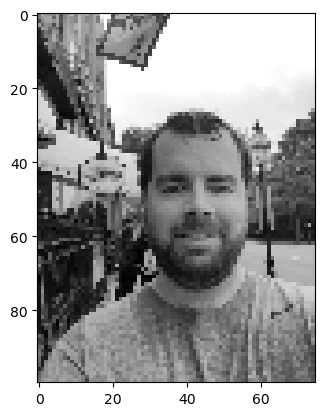

In [ ]:
plt.imshow(train_lab_images[1][..., 0], cmap="gray")
plt.show()